/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,513 (33.25 KB)

 Trainable params: 8,513 (33.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 100/800 -> Train Loss: 0.00935363, Val Loss: 0.00942420
Epoch 200/800 -> Train Loss: 0.00024921, Val Loss: 0.00024619
Epoch 300/800 -> Train Loss: 0.00012505, Val Loss: 0.00012436
Epoch 400/800 -> Train Loss: 0.00019773, Val Loss: 0.00012119
Epoch 500/800 -> Train Loss: 0.00005019, Val Loss: 0.00005003
Epoch 600/800 -> Train Loss: 0.00003246, Val Loss: 0.00018737
Epoch 700/800 -> Train Loss: 0.00002156, Val Loss: 0.00002150
Epoch 800/800 -> Train Loss: 0.00032991, Val Loss: 0.00080714

--- 最終誤差評估 ---
訓練集 - 函數 MSE: 0.00008018
訓練集 - 導數 MSE: 0.00024972
驗證集 - 函數 MSE: 0.00020296
驗證集 - 導數 MSE: 0.00060419


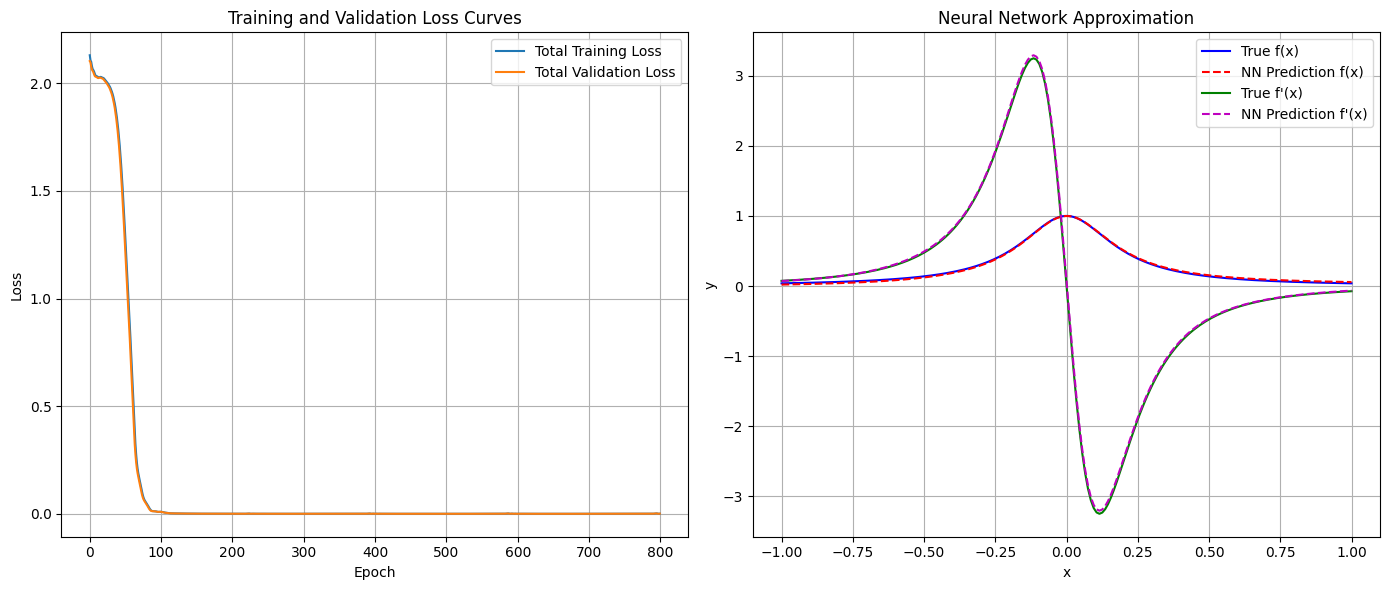

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 1. 定義 Runge 函數及其真實導數
def runge_function(x):
    """計算 Runge 函數 f(x) = 1 / (1 + 25x^2)"""
    return 1 / (1 + 25 * x**2)

def runge_derivative(x):
    """計算 Runge 函數的導數 f'(x) = -50x / (1 + 25x^2)^2"""
    return -50 * x / (1 + 25 * x**2)**2

# 2. 準備數據
# 在 -1 到 1 之間生成訓練和驗證數據點
x_train = tf.convert_to_tensor(np.linspace(-1, 1, 1000), dtype=tf.float32)[:, tf.newaxis]
y_train_f = runge_function(x_train)
y_train_df = runge_derivative(x_train)

x_val = tf.convert_to_tensor(np.linspace(-1, 1, 400), dtype=tf.float32)[:, tf.newaxis]
y_val_f = runge_function(x_val)
y_val_df = runge_derivative(x_val)

# 3. 建立神經網路模型
# 一個簡單的多層感知機 (MLP)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh', input_shape=(1,)),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(1) # 輸出層
])

model.summary()

# 4. 設定訓練參數
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse = tf.keras.losses.MeanSquaredError()
epochs = 800
# 用於平衡函數損失和導數損失的權重
lambda_weight = 1.0

# 用於記錄損失歷史
history = {
    'train_loss': [],
    'val_loss': [],
    'train_f_loss': [],
    'train_df_loss': [],
    'val_f_loss': [],
    'val_df_loss': []
}

# 5. 自訂訓練步驟函數
@tf.function
def train_step(x, y_f, y_df):
    with tf.GradientTape() as tape_total:
        # 需要監控輸入 x 以計算其梯度
        with tf.GradientTape() as tape_df:
            tape_df.watch(x)
            # 預測函數值
            y_pred_f = model(x, training=True)

        # 計算預測的導數
        y_pred_df = tape_df.gradient(y_pred_f, x)

        # 計算兩個部分的損失
        loss_f = mse(y_f, y_pred_f) # 函數損失
        loss_df = mse(y_df, y_pred_df) # 導數損失

        # 總損失
        total_loss = loss_f + lambda_weight * loss_df

    # 計算總損失對模型權重的梯度並更新
    grads = tape_total.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, loss_f, loss_df

# 6. 自訂驗證步驟函數
@tf.function
def validation_step(x, y_f, y_df):
    with tf.GradientTape() as tape_df:
        tape_df.watch(x)
        y_pred_f = model(x, training=False)
    y_pred_df = tape_df.gradient(y_pred_f, x)

    loss_f = mse(y_f, y_pred_f)
    loss_df = mse(y_df, y_pred_df)
    total_loss = loss_f + lambda_weight * loss_df

    return total_loss, loss_f, loss_df

# 7. 執行訓練迴圈
for epoch in range(epochs):
    # 訓練
    train_loss, train_f_loss, train_df_loss = train_step(x_train, y_train_f, y_train_df)

    # 驗證
    val_loss, val_f_loss, val_df_loss = validation_step(x_val, y_val_f, y_val_df)

    # 記錄歷史數據
    history['train_loss'].append(train_loss.numpy())
    history['val_loss'].append(val_loss.numpy())
    history['train_f_loss'].append(train_f_loss.numpy())
    history['train_df_loss'].append(train_df_loss.numpy())
    history['val_f_loss'].append(val_f_loss.numpy())
    history['val_df_loss'].append(val_df_loss.numpy())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} -> "
              f"Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}")


# 8. 評估與視覺化結果
print("\n--- 最終誤差評估 ---")
# 計算最終的 MSE
final_train_mse_f = history['train_f_loss'][-1]
final_train_mse_df = history['train_df_loss'][-1]
final_val_mse_f = history['val_f_loss'][-1]
final_val_mse_df = history['val_df_loss'][-1]

print(f"訓練集 - 函數 MSE: {final_train_mse_f:.8f}")
print(f"訓練集 - 導數 MSE: {final_train_mse_df:.8f}")
print(f"驗證集 - 函數 MSE: {final_val_mse_f:.8f}")
print(f"驗證集 - 導數 MSE: {final_val_mse_df:.8f}")

# 產生預測值以進行繪圖
x_plot = tf.convert_to_tensor(np.linspace(-1, 1, 200), dtype=tf.float32)[:, tf.newaxis]
with tf.GradientTape() as tape:
    tape.watch(x_plot)
    y_pred_f_plot = model(x_plot)
y_pred_df_plot = tape.gradient(y_pred_f_plot, x_plot)


# 繪製訓練/驗證損失曲線
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Total Training Loss')
plt.plot(history['val_loss'], label='Total Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 繪製函數及其導數的逼近結果
plt.subplot(1, 2, 2)
# 繪製函數
plt.plot(x_plot, runge_function(x_plot), 'b-', label='True f(x)')
plt.plot(x_plot, y_pred_f_plot, 'r--', label='NN Prediction f(x)')
# 繪製導數
plt.plot(x_plot, runge_derivative(x_plot), 'g-', label="True f'(x)")
plt.plot(x_plot, y_pred_df_plot, 'm--', label="NN Prediction f'(x)")
plt.title('Neural Network Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()